In [74]:
from pandas import read_csv

def read_data(file_path, num_features = 1):
    series_influ_A_df = read_csv(file_path, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

    # because since 2011-03-01 It was announced that the H1N12009 flu had been controlled and treated as regular seasonal flu and
    # since 2020-02-01, it's time for covid 
    
    series_influ_A_df = series_influ_A_df.loc [(series_influ_A_df['Month'] >='2011-04-01') & (series_influ_A_df['Month'] <='2020-02-01')]
    return series_influ_A_df.dropna()

file_path = '../data/vietnam_flu_A_month.csv'
#Load data set
df = read_data(file_path)

In [66]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Month'], y=df['case'], mode='lines+markers', name=f'Influenza A Cases in month'))
fig.update_layout(
    title='abc',
    xaxis=dict(
        title='Month',
        tickvals=df['Month'],  
        tickformat='%Y-%m',
        tickangle=90,
    ),
    yaxis=dict(title='Number of Cases'),
    showlegend=True,
)

# Show plot
fig.show()

In [103]:
import numpy as np
# def create_dataset(dataset, look_back=2, num_predict=1):
#     dataX, dataY = [], []
#     for i in range(0, len(dataset)-2 *look_back+1, look_back - num_predict):
#         a = dataset[i:(i+look_back)]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back - num_predict : i+ 2*look_back-num_predict])
#     return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def forecast(input, model):
    input = input.reshape(1, input.shape[0], input.shape[1])
    predicted = model.predict(input, verbose=0)
    return predicted[0]

def make_forecasts(test, model):
    forecasts = []
    inputStart = test[0]
    inputX = inputStart.reshape(1, inputStart.shape[0], inputStart.shape[1])
    for i in range(len(test)):
        predicted = forecast(inputX[i], model)
        forecasts.append(predicted)
        inputXContinue = np.vstack((inputX[-1][1:], predicted))
        inputX = np.append(inputX, [inputXContinue], axis=0)
    
    return forecasts
def evaluate_forecasts(test, forecasts):
    from sklearn.metrics import mean_squared_error
    testScore = np.sqrt(mean_squared_error(test, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))

In [131]:
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

def prepare_data(df, is_ma=False, scaler =None):
    import pandas as pd
    df_ = pd.DataFrame()
    df_["case"] = df[["case"]]
    if is_ma:
        # Apply Moving Average Filter
        window_size = 2
        
        df_['case'] = moving_average(df_['case'], window_size)
        df_ = df_.dropna()
    dataset = df_.values
    if scaler:
        flattened_dataset = dataset.flatten()
        dataset = scaler.fit_transform(flattened_dataset.reshape(-1,1))
        dataset = dataset.reshape(dataset.shape)
    return adf, dataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
adf, dataset = prepare_data(df, scaler=scaler, is_ma=True)

In [132]:

#process data
num_predict = 5
look_back = 10
test_size = num_predict * 2
train = dataset[: -test_size,:]
test = dataset[-test_size - look_back:,:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [133]:
# i = 86
# print(trainX[i], trainY[i])
# len(trainX)
# j=0
# print(testX[j], testY[j])
import tensorflow as tf
from keras.losses import mean_squared_error
def custom_loss(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred))

In [134]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Input, Dropout, GRU,concatenate
from sklearn.model_selection import GridSearchCV
from keras.saving import register_keras_serializable
from sklearn.metrics import r2_score


# hybrid model

# def build_model(input_shape, dropout=None, dense_units = [], unit=64, optimizer='adam'):
#     input = Input(shape=input_shape)
#     # LSTM Model
#     lstm_model = Sequential([
#         LSTM(64),
#         Dense(activation='relu', units=16)
#     ])
#     lstm_model1 = Sequential([
#         LSTM(32),
#         Dense(activation='relu', units=16)
#     ])

#     # GRU Model
#     gru_model = Sequential([
#         # Input(input_shape=input_shape),
#         GRU(32),
#         Dense(activation='relu', units=16)
#     ])
#     # gru_model1 = Sequential([
#     #     # Input(input_shape=input_shape),
#     #     GRU(64),
#     #     Dense(activation='relu', units=16)
#     # ])

#     lstm_output = lstm_model(input)
#     lstm_output1 = lstm_model1(input)
#     gru_output = gru_model(input)
#     # gru_output1 = gru_model1(input)

#     combined_output = concatenate([lstm_output, gru_output, lstm_output1])

#     dense_layers = Sequential([
#     Dense(units=input_shape[1], activation='sigmoid' )
#     ])

#     final_output = dense_layers(combined_output)
#     model = tf.keras.Model(inputs=input, outputs=final_output)
#     model.compile(optimizer=optimizer, loss=custom_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

def build_model(input_shape, dropout=None, unit=64, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=unit, activation='relu'))
    # model.add(LSTM(units=32, activation='relu'))
    model.add(Dense(units=input_shape[1], activation='sigmoid' ))
    model.compile(optimizer=optimizer, loss=custom_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


In [140]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
model = build_model(input_shape=(trainX.shape[1], trainX.shape[2]), unit=64)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
file_path = os.path.join('../model', 'test.keras')

mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)

model.fit(trainX, trainY,batch_size=1, callbacks=[es, mc], verbose=0, epochs=200)


Epoch 1: loss improved from inf to 0.21274, saving model to ../model\test.keras

Epoch 2: loss improved from 0.21274 to 0.15807, saving model to ../model\test.keras

Epoch 3: loss did not improve from 0.15807

Epoch 4: loss improved from 0.15807 to 0.15211, saving model to ../model\test.keras

Epoch 5: loss improved from 0.15211 to 0.15129, saving model to ../model\test.keras

Epoch 6: loss improved from 0.15129 to 0.14815, saving model to ../model\test.keras

Epoch 7: loss improved from 0.14815 to 0.13977, saving model to ../model\test.keras

Epoch 8: loss improved from 0.13977 to 0.13276, saving model to ../model\test.keras

Epoch 9: loss improved from 0.13276 to 0.13112, saving model to ../model\test.keras

Epoch 10: loss improved from 0.13112 to 0.12046, saving model to ../model\test.keras

Epoch 11: loss improved from 0.12046 to 0.11614, saving model to ../model\test.keras

Epoch 12: loss improved from 0.11614 to 0.10829, saving model to ../model\test.keras

Epoch 13: loss improv

In [142]:
# from keras.models import load_model
# file_path = os.path.join('../model', 'test.keras')
# model = load_model(file_path, custom_objects={"custom_loss": custom_loss})


forecasts = make_forecasts(testX, model)
# invert predictions
forecasts = scaler.inverse_transform(forecasts)
testY_ = scaler.inverse_transform(testY)
evaluate_forecasts(testY_[:,0].reshape(-1), forecasts[:, 0].reshape(-1))

Test Score: 13.35 RMSE


In [119]:
def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = np.empty([forecasts.shape[0]])
    forecastsPlot[:] = np.nan
    forecastsPlot[:] = forecasts[:,0].reshape(-1)
    testPlot = np.empty([testY.shape[0]])
    testPlot[:] = np.nan
    testPlot[:] = testY[:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast", marker='x')
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()

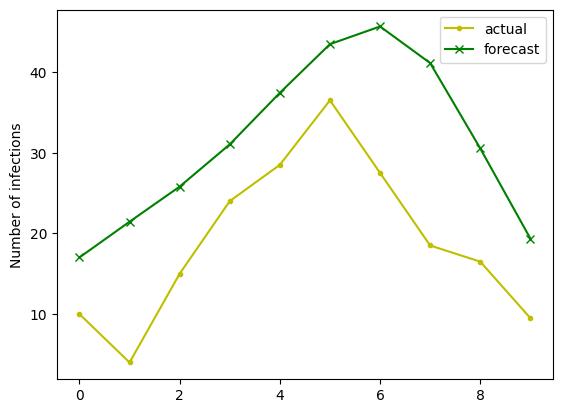

In [143]:
plot(testY_, forecasts)

In [144]:
r2 = r2_score(testY_.flatten(), forecasts.flatten())
r2

-0.9538240560518605

In [138]:

import pandas as pd

def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()
ma_df = df[["Month", "case"]]
# Áp dụng Moving Average Filter
window_size = 2  # Bạn có thể điều chỉnh kích thước cửa sổ tùy ý
ma_df['case_ma'] = moving_average(ma_df['case'], window_size)
ma_df = ma_df.dropna()
# ma_df['case_ma'].plot()

fig = go.Figure()
fig.add_trace(go.Scatter(x=ma_df['Month'], y=ma_df['case_ma'], mode='lines+markers', name=f'Influenza A Cases in month'))
fig.update_layout(
    title='abc',
    xaxis=dict(
        title='Month',
        tickvals=ma_df['Month'],  
        tickformat='%Y-%m',
        tickangle=90,
    ),
    yaxis=dict(title='Number of Cases'),
    showlegend=True,
)

# Show plot
fig.show()


<Axes: >

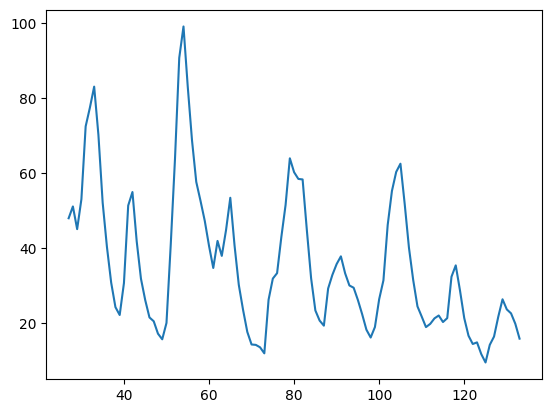

In [29]:
def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()
ema_df = df[["Month", "case"]]

# Áp dụng Exponential Moving Average
span = 6  # Bạn có thể điều chỉnh độ dài span tùy ý
ema_df['case_ema'] = exponential_moving_average(ema_df['case'], span)

ema_df['case_ema'].plot()